In [67]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [68]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [69]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Посмотрим на кореллограммы, чтобы оценить данный временной ряд. Рял не стационарный и имеет сезонность  и тренд. Кроме того, присутствует увеличивающаяся дисперсия. По-хорошему надо использовать метод SARIMA, но в качестве эксперимента мы будем использовать ARIMA. Из PCAF видно, что период сезонности равен 17. Из ACF видно, что ряд не стационарный - присутствуют пеньки выше границы значимости. Об этом же и говорит тет Дикии-Фуллера (0,98 >> 0,05). Остатки относитеьно близки к нормальному распределению.
Попробуем определить вручную параметры pqd для ВР. 
 - d=1 Если применить дифференцирование один раз, то ряд не стационарен, так как p-value = 0,09, но это примерно. если применить второй раз, то уже стационраный. Если сразу применить дифференцирование с лагом 17, то ряд стационарен, так как p-value = 4e-13.
 - p=3 по PACF видно, что пеньки 1,2,3 лагов значительно выходят за границу значимости. все остальные не настолько важны
 - q=2 по ACF видно, что пеньки 1,2 лагов значительно выходят за границу значимости. все остальные не настолько важны

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


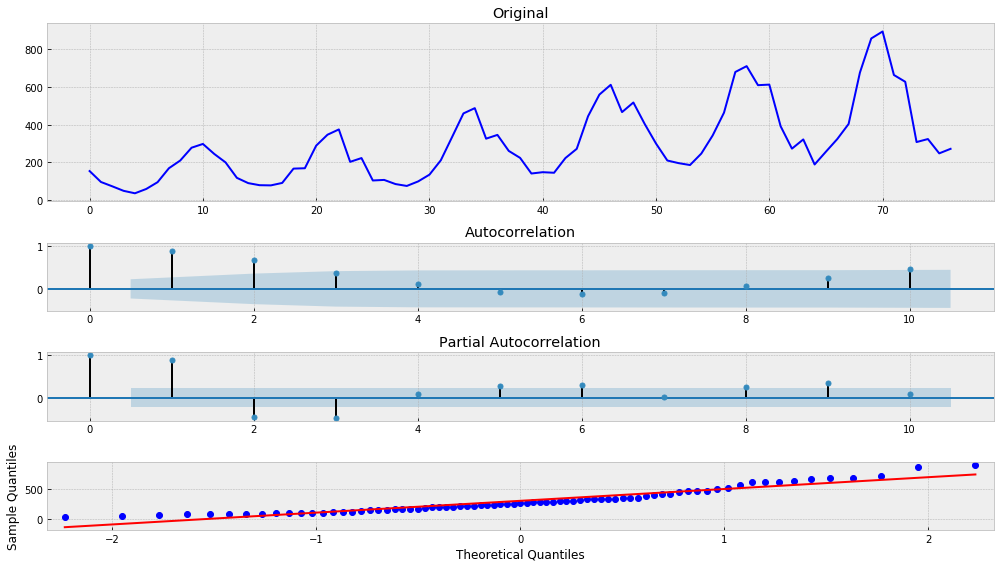

In [70]:
tsplot(sales_of_company_x['Count'], lags=10)

Применим данные параметры и построим модель на основе модели ARIMA. Видимо, что распределние остатков близко к нормальному. Модель достаточно сносно предсказала границы, но не очень хорошо сам график. По кореллораммам видны небольшие автокорреляции за границей значимости. на QQ плоте видно, что данные по центру не идеально легли на эталонную прямую, плюс хвосты по краям имеют отклонения. следовательно, можно еще поработать над улучшением.

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Results of Dickey-Fuller Test:
Test Statistic                 -2.024885
p-value                         0.275770
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


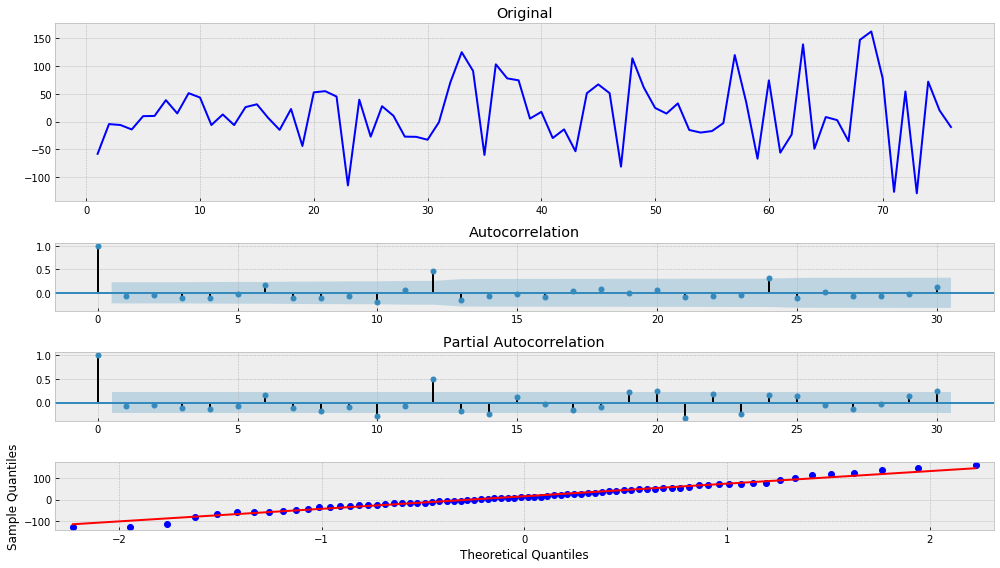

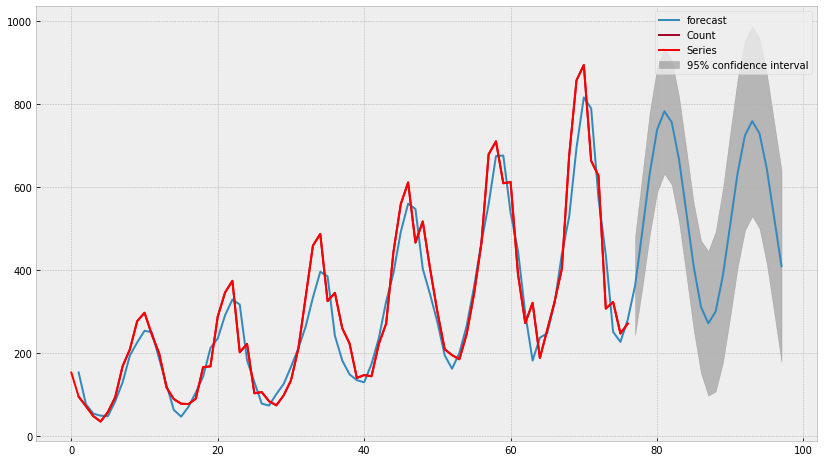

aic: 858.17298


In [71]:
series = sales_of_company_x['Count']
arima_man = smt.ARIMA(series , order=(3,1,2)).fit(method='mle', trend='nc')
tsplot(arima_man.resid, lags=30)
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    arima_man.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()
print('aic: {:6.5f}'.format(arima_man.aic))

Рассмотрим коэффициенты для AR (количество значений назад для вычисления регрессии) и MA. Граница занчимости находится в норме, то есть <0,05

In [72]:
arima_man.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Count   No. Observations:                   76
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -423.086
Method:                           mle   S.D. of innovations             60.549
Date:                Wed, 11 Aug 2021   AIC                            858.173
Time:                        15:26:50   BIC                            872.157
Sample:                             1   HQIC                           863.762
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Count     1.3556      0.116     11.730      0.000       1.129       1.582
ar.L2.D.Count    -0.3700      0.199     -1.863      0.062      -0.759       0.019
ar.L3.D.Count    -0.3523      0.117     -3.019      0.003      -0.581      -0.124
ma.L1.D.Count    -1.8054      0.098    -18.462      0.000      -1.997      -1.614
ma.L2.D.Count     0.9219      0.081     11.377      0.000       0.763       1.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8710           -0.5078j            1.0082           -0.0840
AR.2            0.8710           +0.5078j            1.0082            0.0840
AR.3           -2.7923           -0.0000j            2.7923           -0.5000
MA.1            0.9792           -0.3549j            1.0415           -0.0553
MA.2            0.9792           +0.3549j            1.0415            0.0553
-----------------------------------------------------------------------------
"""

Распределение остатков можно считать подчиняющимся нормальному распределению.

In [73]:
#если p-value низкое, то распределение нельзя считать нормальным
from scipy import stats
from scipy.stats import normaltest
print(normaltest(arima_man.resid))

NormaltestResult(statistic=0.678498313104241, pvalue=0.7123049515319884)


Подберем оптимальные параметры pdq для модели ARIMA. Они совпадают с теми, что мы выбрали.

In [74]:

series = sales_of_company_x['Count']

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
                    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
            except: continue
                

print('Best result:')
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


aic: 1050.71026 | order: (0, 0, 1)
aic: 934.63474 | order: (0, 0, 4)
aic: 913.87555 | order: (0, 1, 1)
aic: 903.29759 | order: (0, 1, 2)
aic: 900.84468 | order: (0, 1, 4)
aic: 897.84167 | order: (0, 2, 3)
aic: 897.82238 | order: (0, 2, 4)
aic: 864.46828 | order: (2, 1, 2)
aic: 859.62387 | order: (2, 1, 3)
aic: 858.17298 | order: (3, 1, 2)
Best result:
aic: 858.17298 | order: (3, 1, 2)


Можно еще использовать библиотеки, чтобы подозбрать оптимальные параметры. Как видимо подобрались параме 4,0,2, что не совсем корректно, так как d должен был быть как мнинимум 1. возможно потому что я установил флаг seasonal=False. тем не менее, глядя на распределение остатков такой модели, можно сделать вывод, что она хуже,чем 3,1,2: qq-plot более разбросан по краям

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (17) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=927.890, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1125.964, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=930.972, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1050.710, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=924.278, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=924.306, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=920.428, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=920.172, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=917.855, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=911.490, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=893.201, Time=0.42 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=898.041, Time=0.35 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=875.371, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Ti

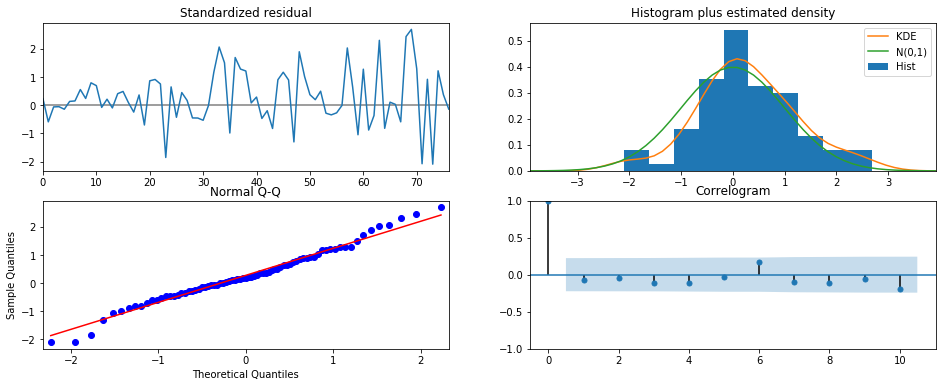

In [75]:
import pmdarima as pm
arima_man2 = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=17,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_man2)
arima_man2.plot_diagnostics(figsize=(16,6))
plt.show()

Оценим качество через показатель RMSE через "кросс-вадидацию":

MAPE =  0.24585108620977406


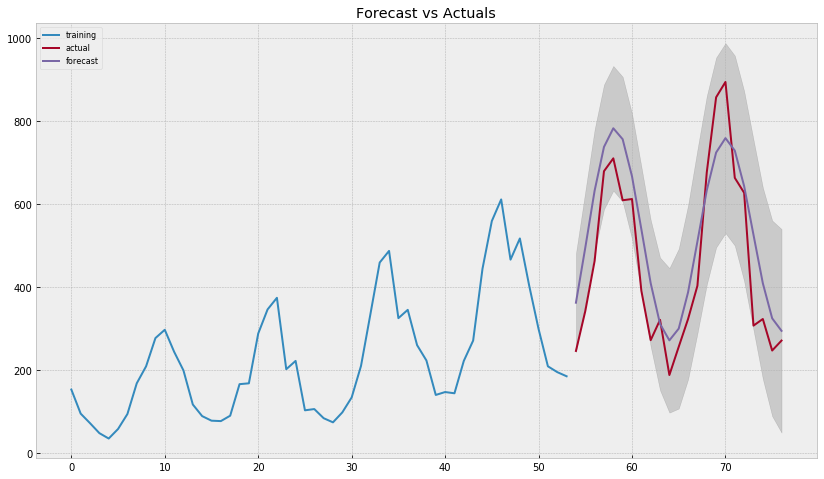

In [76]:
train = series[:54]
test = series[54:]
forecast, se, conf = arima_man.forecast(23, alpha=0.05)

mape = np.mean(np.abs(forecast - test.values)/np.abs(test.values))

print('MAPE = ', mape)

fc_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

Попробуем применить метод SARIMA с заданными вручную параметрами. D=1 означает, что есть сезонность, убираютщаяся одной операцией дифференцирования. s=17 период сезонности. в результате видим улучшение в части AIC и по остаткам тоже более точно выстраиваются края вдоль прямой. но вот предсказание так себе.

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Results of Dickey-Fuller Test:
Test Statistic                 -1.431054
p-value                         0.567301
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


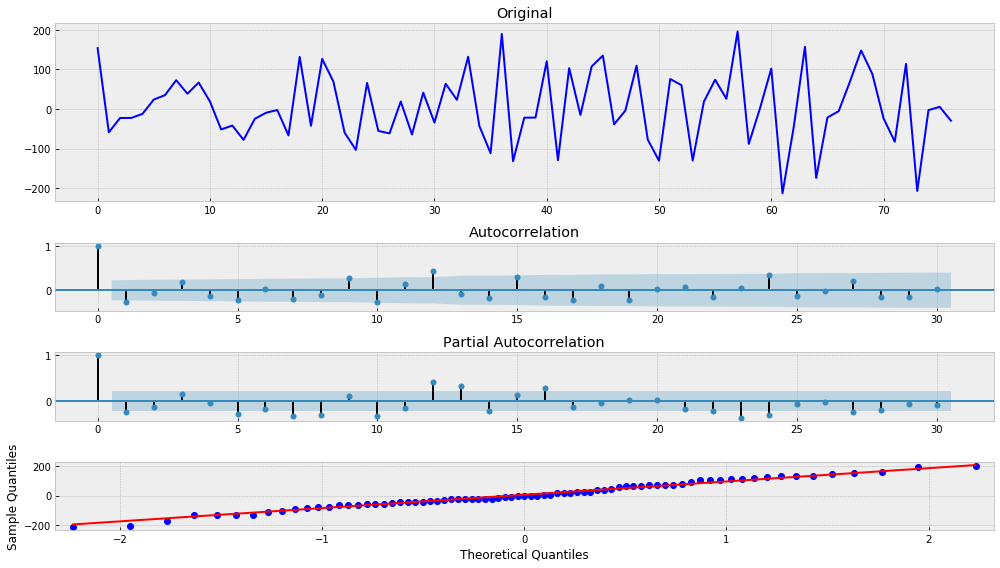

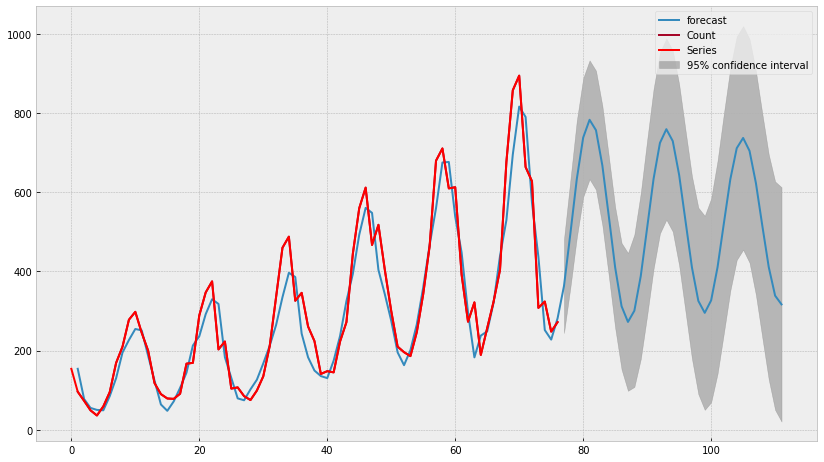

aic: 721.95070


In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_man = SARIMAX(series , order=(3,1,2), seasonal_order=(0,1,0,17)).fit(trend='nc')
tsplot(sarima_man.resid, lags=30)
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    arima_man.plot_predict(1, len(series)+34, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()
print('aic: {:6.5f}'.format(sarima_man.aic))

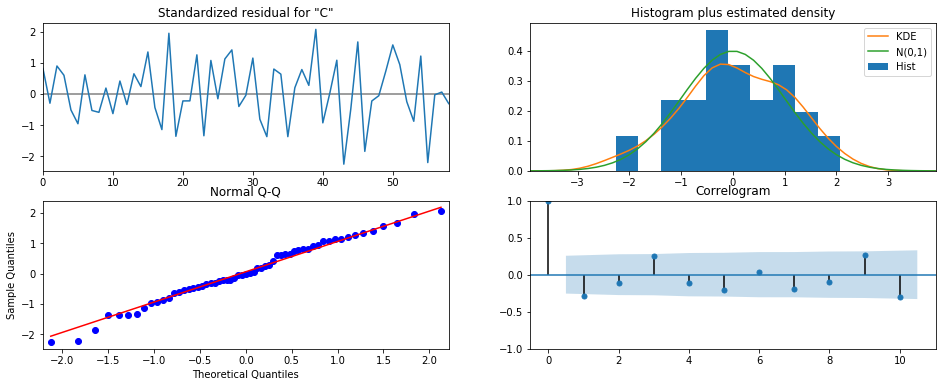

In [78]:
sarima_man.plot_diagnostics(figsize=(16,6))
plt.show()

Попробуем прменить автоматизированный подбор параметров для SARIMA

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[17] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[17] intercept   : AIC=850.374, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[17] intercept   : AIC=755.470, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[17] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[17]             : AIC=854.117, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[17] intercept   : AIC=784.169, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[17] intercept   : AIC=751.444, Time=2.29 sec
 ARIMA(1,0,0)(2,1,1)[17] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(1,0,0)(1,1,1)[17] intercept   : AIC=752.277, Time=1.12 sec
 ARIMA(0,0,0)(2,1,0)[17] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(2,0,0)(2,1,0)[17] intercept   : AIC=737.550, Time=1.79 sec
 ARIMA(2,0,0)(1,1,0)[17] intercept   : AIC=735.552, Time=0.65 sec
 ARIMA(2,0,0)(0,1,0)[17] intercept   : AIC=755.104, Time=0.11 sec
 ARIMA(2,0,0)(1,1,1)[17] intercept   : AIC=737.550, Time=1.11 sec
 ARIMA(2,0,0)(0,1,1)[17] intercept   : AIC=740.40

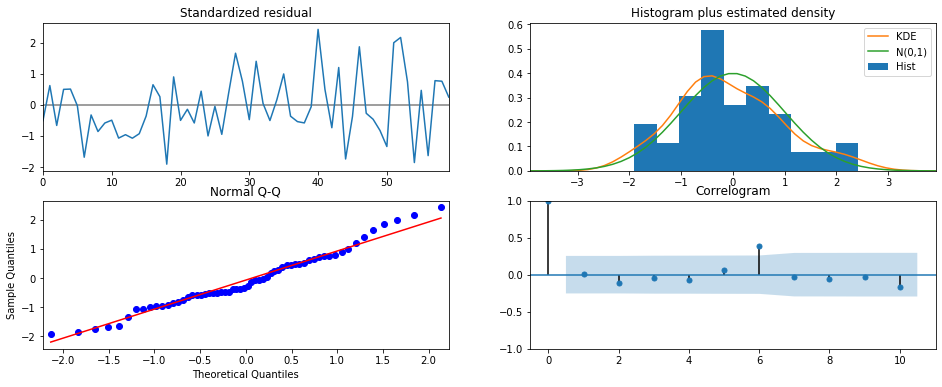

In [79]:
sarima_auto = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=17,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(sarima_auto)
sarima_auto.plot_diagnostics(figsize=(16,6))
plt.show()

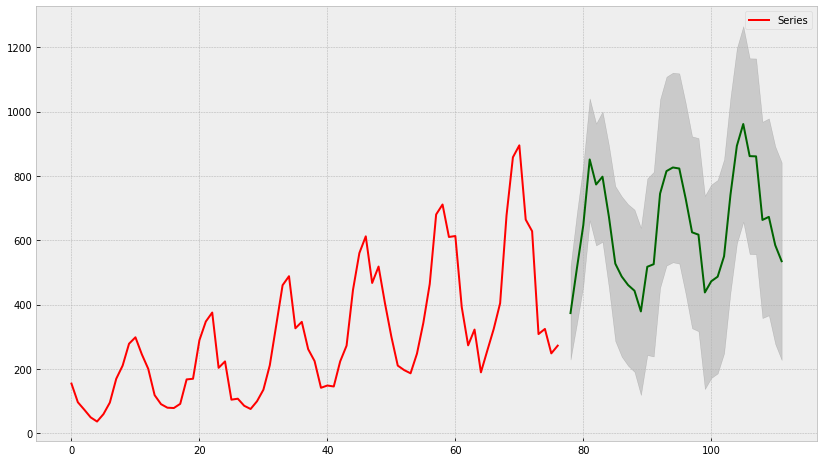

In [80]:
n_periods = 34

fitted, confint = sarima_auto.predict(n_periods=n_periods, return_conf_int=True)

fitted_series = pd.Series(fitted, index = range(len(series)+1, len(series)+1+n_periods))
lower_series = pd.Series(confint[:, 0], index = range(len(series)+1, len(series)+1+n_periods))
upper_series = pd.Series(confint[:, 1], index = range(len(series)+1, len(series)+1+n_periods))

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    plt.plot(fitted_series, color='darkgreen')
    plt.plot(series, color='red', label='Series')
    plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
    plt.legend()
    plt.show()